<a href="https://colab.research.google.com/github/ahmedsalahj-1/gemini-ai-in-command-line/blob/main/DeepLearning12th.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. تحميل البيانات من Kaggle
from google.colab import files
files.upload()  # ارفع ملف kaggle.json الخاص بك

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"

# تنزيل البيانات من Kaggle
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

# فك الضغط من الملف الذي تم تنزيله
import zipfile

# فك ضغط الملف بشكل صحيح
with zipfile.ZipFile("/content/skin-cancer-mnist-ham10000.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")


Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
skin-cancer-mnist-ham10000.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:

# التأكد من وجود الملفات بعد فك الضغط
os.listdir("/content/dataset")



['hmnist_8_8_RGB.csv',
 'HAM10000_metadata.csv',
 'ham10000_images_part_2',
 'HAM10000_images_part_2',
 'ham10000_images_part_1',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_L.csv',
 'HAM10000_images_part_1',
 'hmnist_28_28_L.csv']

In [ ]:
# الاستيراد اللازم
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


<ipython-input-4-8ff828c79265>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data_counts.index, y=data_counts.values, palette='viridis')


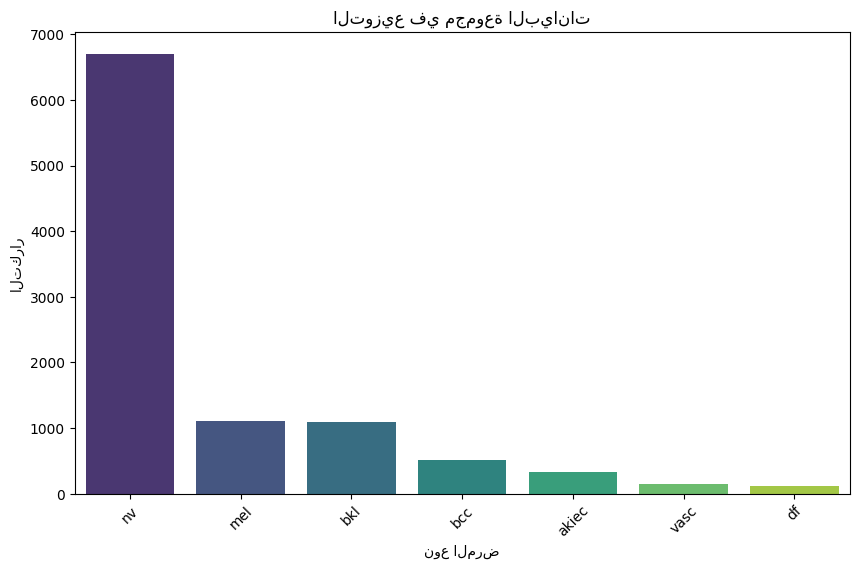

In [ ]:
# قراءة بيانات البيانات الوصفية
tabular_data = pd.read_csv('/content/dataset/HAM10000_metadata.csv')
print(tabular_data.head())

# معالجة البيانات الوصفية (التعرف على عدد الأنواع المختلفة)
column_to_plot = 'dx'
data_counts = tabular_data[column_to_plot].value_counts()

# رسم توزيع الأنواع
plt.figure(figsize=(10, 6))
sns.barplot(x=data_counts.index, y=data_counts.values, palette='viridis')
plt.title('التوزيع في مجموعة البيانات')
plt.xlabel('نوع المرض')
plt.ylabel('التكرار')
plt.xticks(rotation=45)
plt.show()



In [ ]:


# تحميل بيانات الصور (البيانات الخاصة بالنماذج)
data = pd.read_csv('/content/dataset/hmnist_28_28_RGB.csv')

# الفصل بين البيانات والملصقات
x = data.drop('label', axis=1)
y = data['label']


# طباعة عدد العينات قبل إعادة التوازن
print("Before Oversampling:")
print(f"Total samples: {len(x)}")
print(y.value_counts())  # توزيع الفئات


# إعادة التوازن باستخدام oversampling
oversample = RandomOverSampler(random_state=42)
x_resampled, y_resampled = oversample.fit_resample(x, y)

# إعادة تشكيل البيانات للأبعاد المطلوبة
x_resampled = np.array(x_resampled).reshape(-1, 28, 28, 3)

# Normalization
mean = np.mean(x_resampled)
std = np.std(x_resampled)
x_resampled = (x_resampled - mean) / std

# تقسيم البيانات
X_train, X_test, Y_train, Y_test = train_test_split(
    x_resampled, y_resampled, test_size=0.2, random_state=1
)

print(f'Training set size: {X_train.shape}, Testing set size: {X_test.shape}')


Before Oversampling:
Total samples: 10015
label
4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Training set size: (37548, 28, 28, 3), Testing set size: (9387, 28, 28, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Input

model = Sequential([
    Input(shape=(28, 28, 3)),  # تحديد المدخلات
    Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')  # 7 فئات نهائية (لأن مجموع البيانات يحتوي 7 أنواع)
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 137,607 (537.53 KB)

 Trainable params: 137,607 (537.53 KB)

 Non-trainable params: 0 (0.00 B)

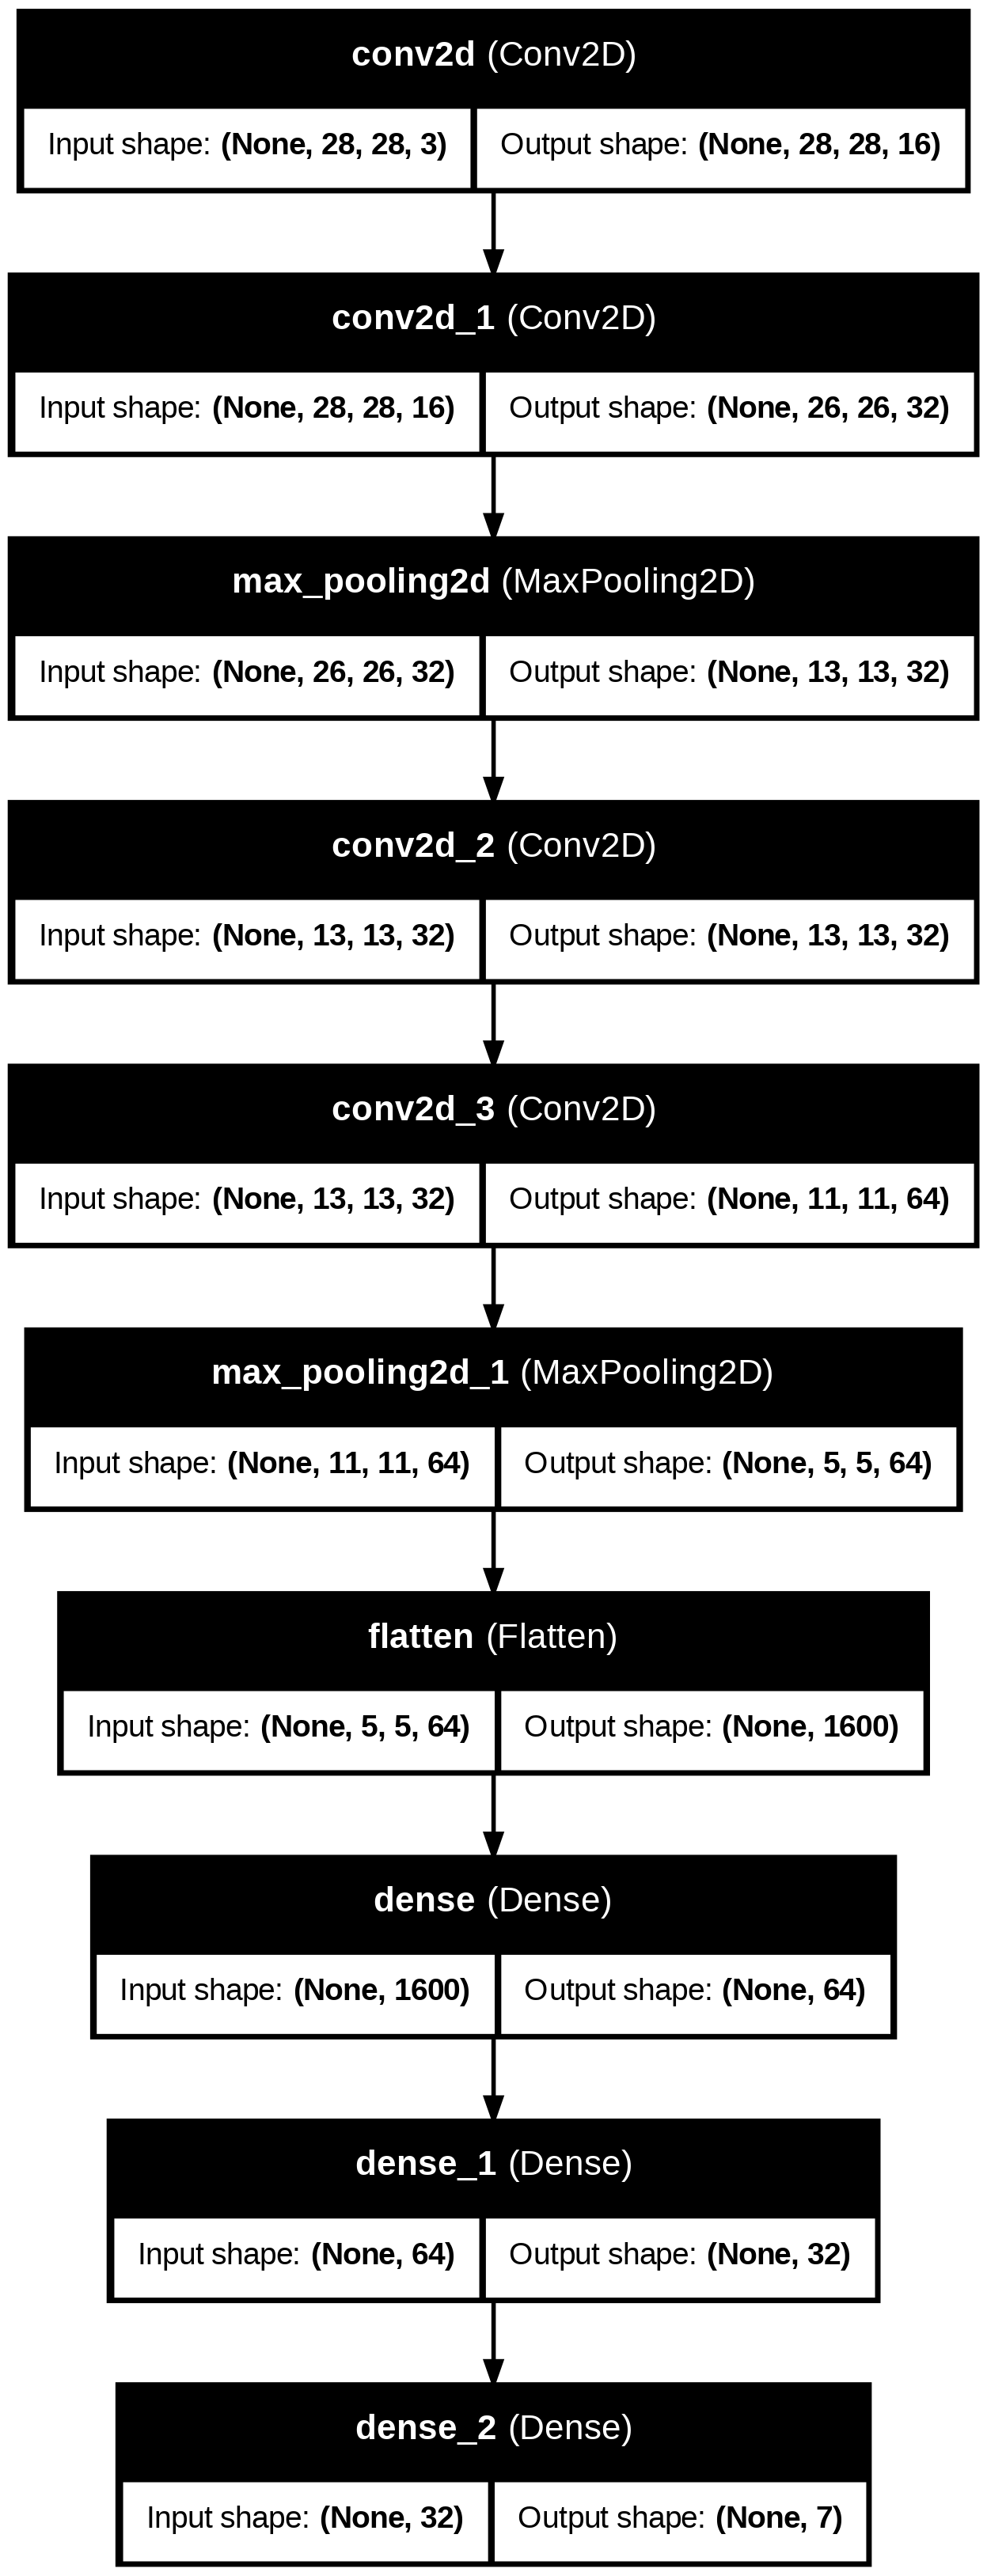

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# رسم النموذج وحفظه كصورة
plot_model(
    model,                      # النموذج الذي أنشأته
    to_file="cnn_model.png",    # اسم ملف الصورة
    show_shapes=True,           # عرض أشكال المدخلات والمخرجات لكل طبقة
    show_layer_names=True       # عرض أسماء الطبقات
)

# عرض الصورة داخل الكود (خاص بـ Google Colab أو Jupyter Notebook)
Image("cnn_model.png")


In [ ]:
# قراءة البيانات من ملف الصور
data = pd.read_csv('/content/dataset/hmnist_28_28_RGB.csv')

# عرض الحجم
print(f"Total number of samples in the dataset: {data.shape[0]}")
print(f"Shape of one image data vector: {data.shape[1]}")


Total number of samples in the dataset: 10015
Shape of one image data vector: 2353


In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    X_train, Y_train,
    validation_split=0.2,  # نسبة للتأكد من الأداء عبر مجموعة التحقق
    epochs=15,
    batch_size=128
)


Epoch 1/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.3859 - loss: 1.5135 - val_accuracy: 0.6044 - val_loss: 0.9965
Epoch 2/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6605 - loss: 0.8937 - val_accuracy: 0.7441 - val_loss: 0.6811
Epoch 3/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7837 - loss: 0.5932 - val_accuracy: 0.8234 - val_loss: 0.4796
Epoch 4/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8461 - loss: 0.4240 - val_accuracy: 0.8632 - val_loss: 0.3637
Epoch 5/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8844 - loss: 0.3159 - val_accuracy: 0.9003 - val_loss: 0.2735
Epoch 6/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9139 - loss: 0.2364 - val_accuracy: 0.9200 - val_loss: 0.2231
Epoch 7/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9359 - loss: 0.1858 - val_accuracy: 0.9309 - val_loss: 0.1969
Epoch 8/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9476 - loss: 0.1504 - val_accuracy: 

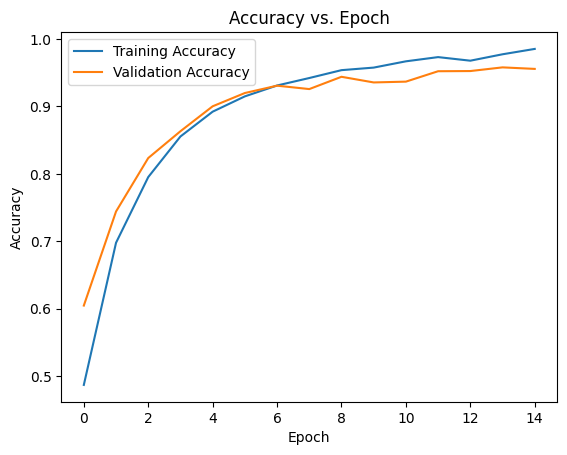

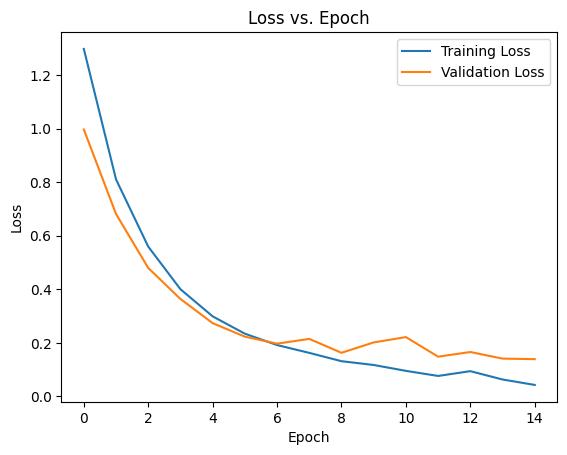

In [ ]:
import matplotlib.pyplot as plt

# Access the training history directly
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# رسم خط بياني للدقة
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epoch')
plt.show()

# رسم خط بياني للخسارة
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epoch')
plt.show()

In [ ]:
model.save('final_model.h5')
print("Saved 'final_model.h5'")


Saved 'final_model.h5'


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f'Test accuracy: {test_accuracy}, Test loss: {test_loss}')


294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9581 - loss: 0.1463
Test accuracy: 0.9563225507736206, Test loss: 0.15043334662914276


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
confusion_mtx = confusion_matrix(Y_test, y_pred_classes)
print("Confusion matrix:\n", confusion_mtx)

# Classification report
print(classification_report(Y_test, y_pred_classes))

294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Confusion matrix:
 [[1359    0    0    0    0    0    0]
 [   0 1315    3    0    0    0    0]
 [   4    6 1122    0  102    0   28]
 [   0    0    0 1351    0    0    0]
 [   7   19   42    1 1167    2  136]
 [   0    0    0    0    0 1358    0]
 [   1    0    1    0   58    0 1305]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1359
           1       0.98      1.00      0.99      1318
           2       0.96      0.89      0.92      1262
           3       1.00      1.00      1.00      1351
           4       0.88      0.85      0.86      1374
           5       1.00      1.00      1.00      1358
           6       0.89      0.96      0.92      1365

    accuracy                           0.96      9387
   macro avg       0.96      0.96      0.96      9387
weighted avg       0.96      0.96      0.96      9387



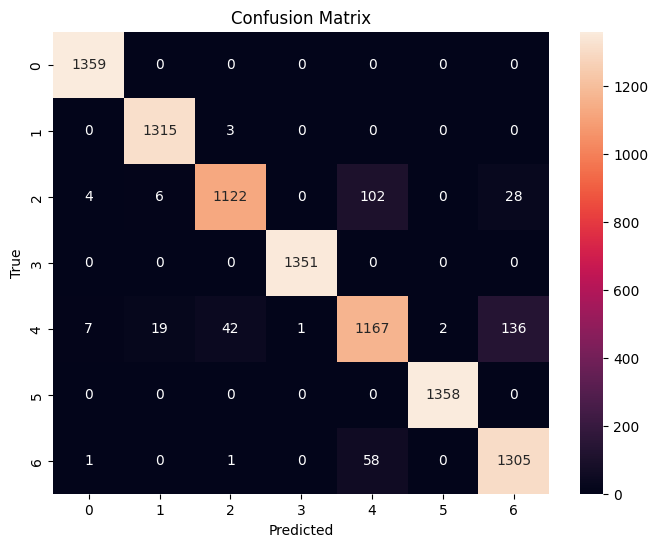

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
# تحميل ResNet50 مع وزن Imagenet وإزالة الطبقة النهائية
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# بناء النموذج الخاص بنا
model = Sequential([
    base_model,  # النموذج الأساسي
    GlobalAveragePooling2D(),  # تسطيح المخرجات
    Dense(64, activation='relu'),  # طبقة خفية
    Dense(7, activation='softmax')  # الطبقة النهائية مع عدد الفئات = 7
])

# تثبيت الطبقات في ResNet50 لعدم تحديث أوزانها أثناء التدريب
for layer in base_model.layers:
    layer.trainable = False

# ملخص النموذج
model.summary()

# إعداد تعزيز البيانات
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# إعادة تشكيل البيانات لتناسب ResNet50
X_train_resized = np.array([np.resize(img, (224, 224, 3)) for img in X_train])
X_test_resized = np.array([np.resize(img, (224, 224, 3)) for img in X_test])


# تجميع النموذج
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,719,303 (90.48 MB)

 Trainable params: 131,591 (514.03 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:

# تدريب النموذج مع تعزيز البيانات
history = model.fit(
    datagen.flow(X_train_resized, Y_train, batch_size=128),
    validation_data=(X_test_resized, Y_test),
    epochs=15
)

Epoch 1/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 187s 763ms/step - accuracy: 0.3262 - loss: 1.6945 - val_accuracy: 0.4691 - val_loss: 1.3910
Epoch 2/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 195s 734ms/step - accuracy: 0.4831 - loss: 1.3487 - val_accuracy: 0.5414 - val_loss: 1.2444
Epoch 3/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 192s 690ms/step - accuracy: 0.5380 - loss: 1.2309 - val_accuracy: 0.5627 - val_loss: 1.1837
Epoch 4/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 214s 742ms/step - accuracy: 0.5674 - loss: 1.1405 - val_accuracy: 0.5913 - val_loss: 1.0984
Epoch 5/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 199s 731ms/step - accuracy: 0.6004 - loss: 1.0698 - val_accuracy: 0.5976 - val_loss: 1.0598
Epoch 6/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 194s 696ms/step - accuracy: 0.6167 - loss: 1.0331 - val_accuracy: 0.6180 - val_loss: 1.0172
Epoch 7/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 245s 882ms/step - accuracy: 0.6298 - loss: 0.9981 - val_accuracy: 0.6202 - val_loss: 1.0030
Epoch 8/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 222s 711ms/step - accuracy: 0.6426 -

In [ ]:

# رسم الخطوط البيانية للدقة والخسارة
plt.figure(figsize=(12, 6))


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

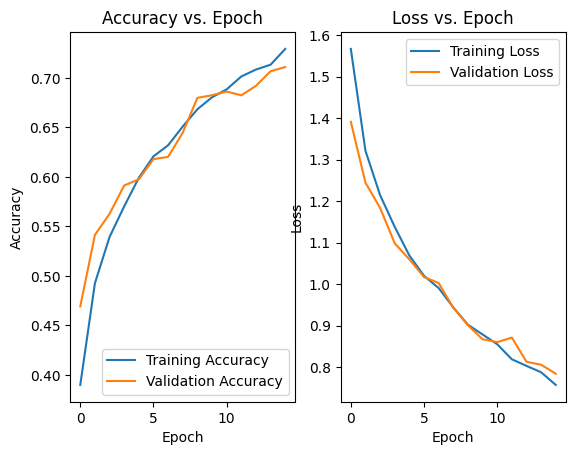

In [ ]:
# الدقة
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epoch')

# الخسارة
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epoch')

plt.show()


In [ ]:
# Evaluation and prediction using the resized test data:
test_loss, test_accuracy = model.evaluate(X_test_resized, Y_test)
print(f'Test accuracy: {test_accuracy}, Test loss: {test_loss}')


294/294 ━━━━━━━━━━━━━━━━━━━━ 48s 164ms/step - accuracy: 0.7085 - loss: 0.7854
Test accuracy: 0.7146053314208984, Test loss: 0.778803825378418


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test_resized)  # Use X_test_resized
y_pred_classes = np.argmax(y_pred, axis=1)

# مصفوفة الالتباس
confusion_mtx = confusion_matrix(Y_test, y_pred_classes)
print("Confusion matrix:\n", confusion_mtx)

# تقرير التصنيف
print(classification_report(Y_test, y_pred_classes))


294/294 ━━━━━━━━━━━━━━━━━━━━ 52s 169ms/step
Confusion matrix:
 [[1147   68   52   69   12    5    6]
 [ 264  756   75  142   27   29   25]
 [ 239  108  593   88  112   25   97]
 [  55    0    0 1296    0    0    0]
 [  72   53  135   85  750   87  192]
 [   8    0    0   22    0 1328    0]
 [ 126   60  170   31  136    4  838]]
              precision    recall  f1-score   support

           0       0.60      0.84      0.70      1359
           1       0.72      0.57      0.64      1318
           2       0.58      0.47      0.52      1262
           3       0.75      0.96      0.84      1351
           4       0.72      0.55      0.62      1374
           5       0.90      0.98      0.94      1358
           6       0.72      0.61      0.66      1365

    accuracy                           0.71      9387
   macro avg       0.71      0.71      0.70      9387
weighted avg       0.71      0.71      0.71      9387



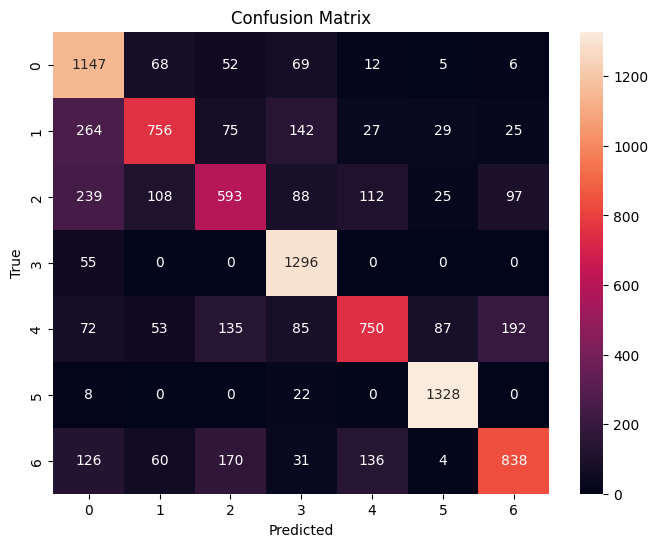

Saved 'resnet50_model.h5'


In [ ]:
# رسم مصفوفة الالتباس
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# حفظ النموذج
model.save('resnet50_model.h5')
print("Saved 'resnet50_model.h5'")
